# Chapter 6 - Linear Model Selection and Regularization

In [14]:
import numpy as np
import pandas as pd
from math import exp, log, sqrt, pi
import time
import itertools
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



#import glmnet as gln

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

## Lab 1: Subset Selection Model

In [20]:
hitters = pd.read_csv('data/Hitters.csv', index_col=0)
hitters.index.name = 'Player'

In [21]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [23]:
hitters.dropna(axis=0, inplace=True)

In [24]:
hitters.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,403.642586,107.828897,11.619772,54.745247,51.486692,41.114068,7.311787,2657.543726,722.186312,69.239544,361.220532,330.418251,260.266160,290.711027,118.760456,8.593156,535.925882
std,147.307209,45.125326,8.757108,25.539816,25.882714,21.718056,4.793616,2286.582929,648.199644,82.197581,331.198571,323.367668,264.055868,279.934575,145.080577,6.606574,451.118681
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,4.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,67.500000
25%,282.500000,71.500000,5.000000,33.500000,30.000000,23.000000,4.000000,842.500000,212.000000,15.000000,105.500000,95.000000,71.000000,113.500000,8.000000,3.000000,190.000000
50%,413.000000,103.000000,9.000000,52.000000,47.000000,37.000000,6.000000,1931.000000,516.000000,40.000000,250.000000,230.000000,174.000000,224.000000,45.000000,7.000000,425.000000
75%,526.000000,141.500000,18.000000,73.000000,71.000000,57.000000,10.000000,3890.500000,1054.000000,92.500000,497.500000,424.500000,328.500000,322.500000,192.000000,13.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1377.000000,492.000000,32.000000,2460.000000


In [32]:
def fit_linear_reg(X, y):
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rss =  mse * len(y)
    r_squared = model.score(X, y)
    return rss, r_squared, mse

def calculate_aic(num_obs, mse, num_params):
    '''
    AIC is derived from a frequentist framework.
    AIC cannot be interpreted as an approximation to the marginal likelihood.
    AIC penalizes complex models less than BIC.
    In general selects more complex models.
    
    '''
    
    aic = num_obs * log(mse) + 2 * num_params
    return aic

def calculate_bic(num_obs, mse, num_params):
    '''
    
    Bayesian method.
    Models fit under the MLE framework.
    If selected candidate models include a true model for the dataset...  
    then the probability that BIC will select the true model increases with the size of the training dataset
    '''
    bic = num_obs * log(mse) + num_params * log(num_obs)
    return bic

In [33]:
y = hitters['Salary']
X = hitters.drop(['League', 'Division', 'Salary', 'NewLeague'], axis=1)
rss_arr, r_sqrd_arr, feature_list = [], [], []
bic_arr, aic_arr = [], []
mse_arr =[]
num_features = []

for feature_idx in trange(1, len(X.columns)+1, desc='Looping...'):
    
    for permu in itertools.combinations(X.columns, feature_idx):
        tmp_rss, tmp_r_sqrd, tmp_mse = fit_linear_reg(X[list(permu)], y)
        rss_arr.append(tmp_rss)
        r_sqrd_arr.append(tmp_r_sqrd)
        mse_arr.append(tmp_mse)
        
        # information criterion metrics
        tmp_aic = calculate_aic(X.shape[0], tmp_mse, len(permu))
        aic_arr.append(tmp_aic)
        
        tmp_bic = calculate_bic(X.shape[0], tmp_mse, len(permu))
        bic_arr.append(tmp_bic)
        
        # record features
        feature_list.append(permu)
        num_features.append(len(permu))
        


Looping...: 100%|██████████| 16/16 [06:35<00:00, 24.73s/it]


In [34]:
df = pd.DataFrame({'num_features': num_features, 'RSS': rss_arr, 'R_Squared': r_sqrd_arr, 'features': feature_list,
                  'AIC': aic_arr, 'BIC': bic_arr})
df.sort_values('R_Squared', ascending=False, inplace=True)
df.head(10)

,num_features,RSS,R_Squared,features,AIC,BIC
65534,16,2.517031e+07,0.527931,"(AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",3048.352688,3105.507153
65529,15,2.517032e+07,0.527931,"(AtBat, Hits, HmRun, Runs, Walks, Years, CAtBa...",3046.352771,3099.935081
65525,15,2.517139e+07,0.527911,"(AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",3046.363982,3099.946292
65460,14,2.517145e+07,0.527909,"(AtBat, Hits, HmRun, Runs, Walks, Years, CAtBa...",3044.364615,3094.374772
65524,15,2.517239e+07,0.527892,"(AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",3046.374399,3099.956710
65459,14,2.517252e+07,0.527889,"(AtBat, Hits, HmRun, Runs, Walks, Years, CAtBa...",3044.375755,3094.385911
65527,15,2.517474e+07,0.527848,"(AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...",3046.399007,3099.981318
65462,14,2.517477e+07,0.527847,"(AtBat, Hits, HmRun, Runs, Walks, CAtBat, CHit...",3044.399329,3094.409486
65440,14,2.517655e+07,0.527814,"(AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...",3044.417885,3094.428041
65045,13,2.517661e+07,0.527813,"(AtBat, Hits, HmRun, Runs, Walks, CAtBat, CHit...",3042.418498,3088.856501


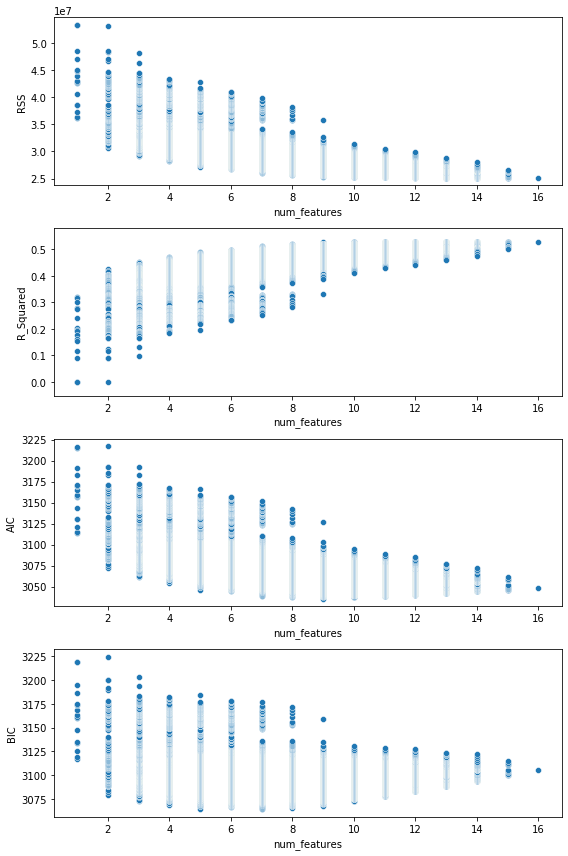

In [37]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 12))
sns.scatterplot(x='num_features', y='RSS', data=df, ax=axes[0])
sns.scatterplot(x='num_features', y='R_Squared', data=df, ax=axes[1])
sns.scatterplot(x='num_features', y='AIC', data=df, ax=axes[2])
sns.scatterplot(x='num_features', y='BIC', data=df, ax=axes[3])
fig.tight_layout();